In [1]:
import pandas
from panoptes_aggregation.csv_utils import unjson_dataframe
# the `data.*` columns are read in as strings instead of arrays
data = pandas.read_csv('point_reducer_dbscan_reductions.csv')
# print(data)
# use unjson_dataframe to convert them to lists
# all values are updated in place leaving null values untouched
# print(data)

In [2]:
import sys, os
import numpy as np
import pandas as pd
import ujson

from basic_classification_processing import basic_stats_processing, basic_stats_help


print("Python version: %d.%d.%d, numpy version: %s, pandas version: %s." %(sys.version_info[0], 
                                                                           sys.version_info[1], 
                                                                           sys.version_info[2], 
                                                                           np.__version__, 
                                                                           pd.__version__))
print("Originally developed using Py 2.7.11, np v1.11.0, pd v0.19.2")
print("If these versions don't match and stuff breaks, that's probably why.")

Python version: 3.10.9, numpy version: 1.23.5, pandas version: 1.5.3.
Originally developed using Py 2.7.11, np v1.11.0, pd v0.19.2
If these versions don't match and stuff breaks, that's probably why.




# Radio Whispers From Our Neighboring Galaxy: Data Aggregation

Some of the code in this notebook is based on (or exactly alike if no modifications were needed, note all panoptes aggregation code is in the public domain, but proper referencing must done if code from other projects is used or modified) that used by Alex Andersson at https://github.com/AnderssonAstro/BfS-MKT-Analysis and on the publically available aggregation scripts on the Zooniverse site (https://github.com/zooniverse/Data-digging/tree/master, https://caesar.zooniverse.org/workflows/).

This notebook is for aggregating the results of the Radio Whispers From Our Neighboring Galaxy Zooniverse project.
We have removed all personal data from volunteers to maintain privacy and anonimity in the aggregated data.

The first few cells are processing the data, combining a few Zooniverse output tables together and writing a few functions to calculate different statistics for the project as a whole, and for each subject individually after that. 
The later cells deal with analysis and plots for the MSc work of Gideon de Beer. The output tables from Zooniverse first went though reducers using the panoptes_aggregation_gui run from terminal locally (offline). If the results need to be replicated please follow the steps in the readme on the gitHub page where this code is archived.

I've not made any attempts at beautifying the code, so please get in touch if something isn't clear!

In [3]:
folder = './'

In [4]:
%matplotlib inline 
#notebook
import pandas as pd

#from panoptes_aggregation.csv_utils import unjson_dataframe
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import sys
import ast
import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
import time
from PyPDF2 import PdfMerger
import pyshorteners
from skimage import io


#sys.path.append(folder + "data-digging/scripts_GeneralPython")

2023-05


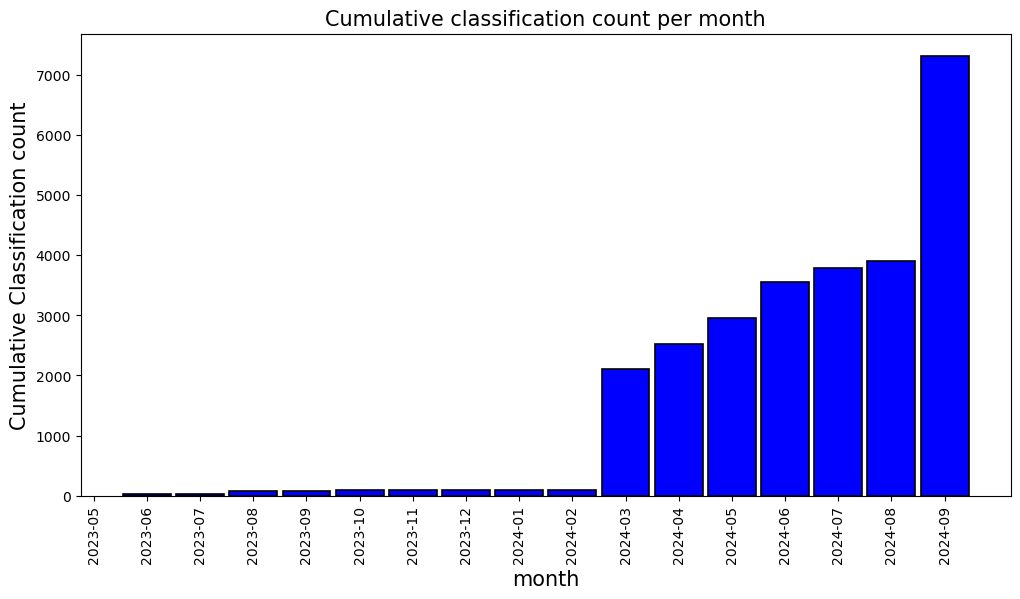

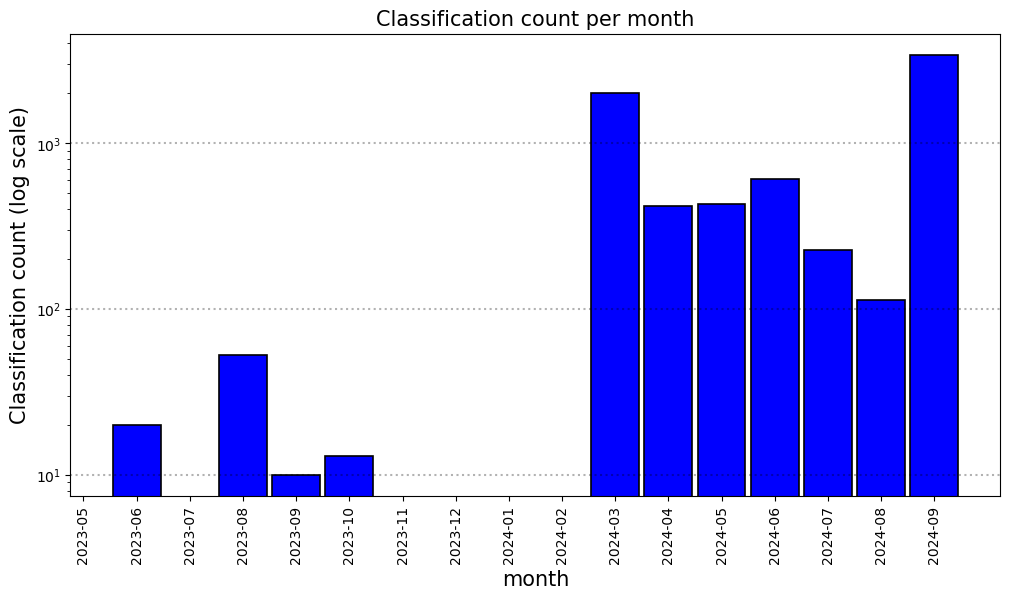

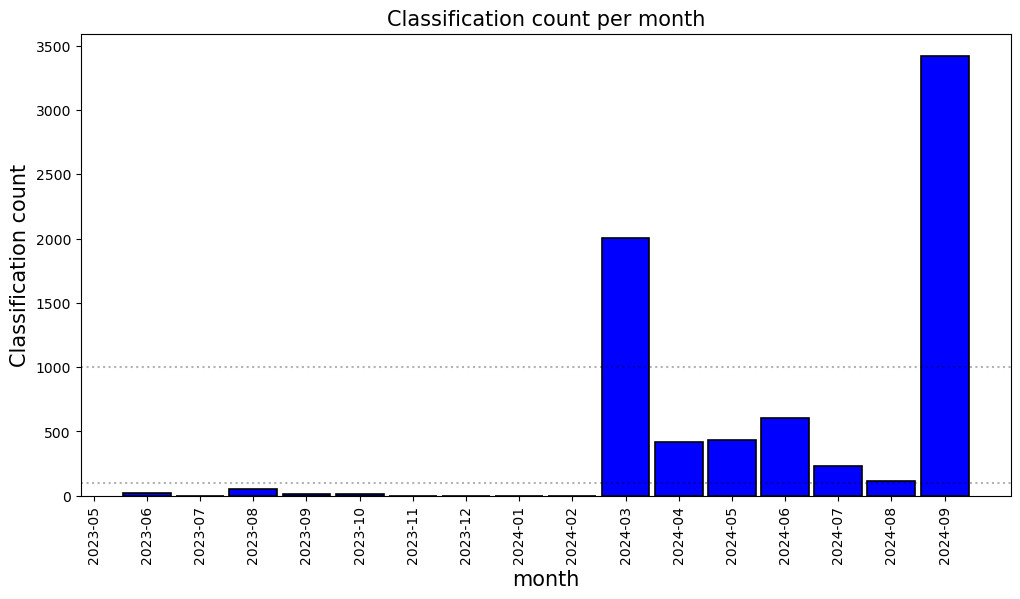

In [5]:
#Histogram for classifications per month
data = pd.read_csv('radio-whispers-from-our-neighbouring-galaxy-classifications.csv') #read in the classifications export

months=['2023-05','2023-06','2023-07','2023-08','2023-09','2023-10','2023-11','2023-12','2024-01',
       '2024-02','2024-03','2024-04','2024-05','2024-06','2024-07','2024-08','2024-09'] #Months over which project had run
counts=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #counts list for classifications each month
print(data['created_at'][0][0:7])

for i in range(0,len(data)):
    c=0
    found=0
    while found==0:
        if data['created_at'][i][0:7]==months[c]:
            counts[c]+=1
            found=1
        c=c+1

        
fSize=10 #base font size
LW=1.2 #line width
rW= 0.9

#Cumulative
plt.figure(figsize=(12,6))
ax = plt.gca()
plt.xticks(rotation=90)
plt.hist(bins=16,x=months,weights=counts, color = 'blue', edgecolor='black', linewidth=LW, cumulative=True,rwidth=rW,align='right')#
plt.title('Cumulative classification count per month', fontsize=fSize+5)
plt.xlabel('month', fontsize=fSize+5)
plt.ylabel('Cumulative Classification count', fontsize=fSize+5)
plt.xticks(fontsize=fSize)
plt.yticks(fontsize=fSize)
plt.savefig('HIST_classifications_Cumulative.pdf', dpi=1000)

#Normal (log scale)
plt.figure(figsize=(12,6))
ax = plt.gca()
plt.xticks(rotation=90)
plt.yscale('log')
plt.hist(bins=16,x=months,weights=counts, color = 'blue', edgecolor='black', linewidth=LW, cumulative=False,rwidth=rW,align='right')#
plt.axhline(y=10, color='black', linestyle='dotted',alpha=0.3)
plt.axhline(y=100, color='black', linestyle='dotted',alpha=0.3)
plt.axhline(y=1000, color='black', linestyle='dotted',alpha=0.3)
plt.title('Classification count per month', fontsize=fSize+5)
plt.xlabel('month', fontsize=fSize+5)
plt.ylabel('Classification count (log scale)', fontsize=fSize+5)
plt.xticks(fontsize=fSize)
plt.yticks(fontsize=fSize)
plt.savefig('HIST_classifications_Normal(log_scale).pdf', dpi=1000)

#Normal (normal scale)
plt.figure(figsize=(12,6))
ax = plt.gca()
plt.xticks(rotation=90)
plt.hist(bins=16,x=months,weights=counts, color = 'blue', edgecolor='black', linewidth=LW, cumulative=False,rwidth=rW,align='right')#
plt.axhline(y=100, color='black', linestyle='dotted',alpha=0.3)
plt.axhline(y=1000, color='black', linestyle='dotted',alpha=0.3)
plt.title('Classification count per month', fontsize=fSize+5)
plt.xlabel('month', fontsize=fSize+5)
plt.ylabel('Classification count', fontsize=fSize+5)
plt.xticks(fontsize=fSize)
plt.yticks(fontsize=fSize)
plt.savefig('HIST_classifications_Normal.pdf', dpi=1000)
    
    
    


In [7]:
# read-in and calculating simple classification fractions.
data = pd.read_csv('question_reducer_reductions.csv') #read in the reducer data output from panoptes_aggregation_gui ran from terminal
data = data.fillna(0)
subjectdata = pd.read_csv('radio-whispers-from-our-neighbouring-galaxy-subjects.csv')
subjectdata.fillna(0)
print(len(data), 'sources classified')

#For Task0 data.yes and data.no refer to the question on if the classifier thought that there was an
#associated optical source or not.

#Task3 Rename the long data col names for convenience (Technically making copies of the cols)
data['multi-source']=data['data.multiple-sources-png-https-panoptes-uploads-zooniverse-org-project-attached-image-dfaf96b9-6480-413e-9cde-c5a4cb46c5c7-png-multiple-sources-inside']
data['homogeneous']=data['data.homogenously-diffuse-png-https-panoptes-uploads-zooniverse-org-project-attached-image-1d169b37-43ad-47de-980f-e8a5a08b1676-png-homogeneously-diffuse-source']
data['point-star']=data['data.point-source-png-https-panoptes-uploads-zooniverse-org-project-attached-image-e813946d-52b9-484e-b818-6c7f632ad6d3-png-point-source-or-star-like']
data['oddORnot-sure']=data['data.oddly-shaped-png-https-panoptes-uploads-zooniverse-org-project-attached-image-b76c4bc8-ddab-4366-9a6c-9c7524ecc2ad-png-oddly-shaped-not-sure']
data['core-in-diffuse']=data['data.bright-core-radial-diffuse-png-https-panoptes-uploads-zooniverse-org-project-attached-image-b80f4e7c-8d77-4cf1-8bb2-c8f24af80628-png-bright-core-in-diffuse-emission']
# print(data.shape)

#drop cols with huge names that have been renamed and all 0 filled cols too
data=data.drop(columns=['data.multiple-sources-png-https-panoptes-uploads-zooniverse-org-project-attached-image-dfaf96b9-6480-413e-9cde-c5a4cb46c5c7-png-multiple-sources-inside',
                        'data.homogenously-diffuse-png-https-panoptes-uploads-zooniverse-org-project-attached-image-1d169b37-43ad-47de-980f-e8a5a08b1676-png-homogeneously-diffuse-source',
                       'data.point-source-png-https-panoptes-uploads-zooniverse-org-project-attached-image-e813946d-52b9-484e-b818-6c7f632ad6d3-png-point-source-or-star-like',
                       'data.oddly-shaped-png-https-panoptes-uploads-zooniverse-org-project-attached-image-b76c4bc8-ddab-4366-9a6c-9c7524ecc2ad-png-oddly-shaped-not-sure',
                       'data.bright-core-radial-diffuse-png-https-panoptes-uploads-zooniverse-org-project-attached-image-b80f4e7c-8d77-4cf1-8bb2-c8f24af80628-png-bright-core-in-diffuse-emission',
                       'data.radio-source-showing-extended-morphology',
                       'data.radio-point-source',
                       'data.point-source-or-star-like',
                       'data.oddly-shaped-not-sure',
                       'data.bright-core-source-becomes-radially-diffuse',
                       'data.multiple-sources-inside',
                       'data.gas-like-region-weirdly-shaped-central-or-not',
                       'data.homogeneously-diffuse-source',
                       'data.None',
                       'data.diffuse-non-central-blob',
                       'data.diffuse-non-central-source',
                       'data.gas-like-region-weirdly-shaped',
                       'data.galaxy-like',
                       'data.very-opaque-emission-source'])

# The columns that were dropped are all empty due to the changes in workflow, however the old names of the data boxes were not removed by Zooniverse.

# print(data.shape)

#Task5 radio point or extended data is in data.the-radio-source-is-showing-extended-morphology +
# data.radio-source-showing-extended-morphology and 


#Task6 on if radio extended source is isolated or connected to nearby marked regions is in
#data.yes-there-seem-to-be-associated-regions-close-to-the-central-source and 
#data.no-nearby-marked-regions-seem-associated-with-the-central-source

data['Sum'] = (data['multi-source']+data['homogeneous']+data['point-star']
              +data['oddORnot-sure']+data['core-in-diffuse']).fillna(0)
data['Total_Class']=(data['data.yes']+data['data.no']).fillna(0)
data['multiFrac'] = data['multi-source'] / data.Sum
data['homoFrac'] = data['homogeneous'] / data.Sum
data['pointFrac'] = data['point-star'] / data.Sum
data['unsureOddFrac'] = data['oddORnot-sure']/data.Sum
data['coreFrac']  =  data['core-in-diffuse']/data.Sum

#These next 2 are columns to indicate the fraction of classifiers who say the radio contours
#indicate a point or extended source.
data['ext_radFrac'] = (data['data.the-radio-source-is-showing-extended-morphology'])/subjectdata.classifications_count
data['point_radFrac']=(data['data.yes-it-looks-like-a-radio-point-source'])/subjectdata.classifications_count

#Create flag columns and default to 0 (or false)
data['flag_rad_point']=0*data['Total_Class']
data['flag_rad_extended']=0*data['Total_Class']
data['flag_rad_unsure']=0*data['Total_Class']
data['flag_optical_counterpart']=0*data['Total_Class']


# this merges the reduced classifications with the original subject data
# allowing us to instantly check the data and metadata (including downloading files from online) for a given subject
data = pd.merge(data, subjectdata, how='inner', on=['subject_id'])
data = pd.concat([data,pd.DataFrame([ast.literal_eval(row) for row in data['metadata']])],axis=1)
data = pd.concat([data,pd.DataFrame([ast.literal_eval(row) for row in data['locations']])],axis=1)
data = data.rename(columns={"0": "LCurl", "1": "Imageurl"})


data.head()

#Now make a new csv file with all the subject and classificatyion data together. ONE BIG TABLE :D
data.to_csv('AAATEST.csv')

#This next segment reduces the data even further by taking out the 'task' column and merging every 4 lines
#pertaining to the same subject into one single line per subject.
#After that the redundant columns are removed that all have the same value and is considered metadata unusable
#for the statistics.
data_red = pd.read_csv('AAATEST_blank2.csv') #read in the columns in the blank csv created by deleting all
                                            #rows containing data, and the task col in AAATEST.csv
    
counter=0
#The column names in the blank, must match the column names being filled into each row.
#The number of columns must hence also match or this will not work.
while counter<=(data.shape[0]-3):
    if data['classifications_count'][counter]!=0:
        new_row=pd.DataFrame({"subject_id":data['subject_id'][counter],
                              "workflow_id_x":data['workflow_id_x'][counter],
                              "reducer":data['reducer'][counter],
                              "data.yes":data['data.yes'][counter],
                              "data.aggregation_version":data['data.aggregation_version'][counter],
                              "data.no":data['data.no'][counter],
                              "data.the-radio-source-is-showing-extended-morphology":data['data.the-radio-source-is-showing-extended-morphology'][counter+2],
                              "data.yes-there-seem-to-be-associated-regions-close-to-the-central-source":data['data.yes-there-seem-to-be-associated-regions-close-to-the-central-source'][counter+3],
                              "data.yes-it-looks-like-a-radio-point-source":data['data.yes-it-looks-like-a-radio-point-source'][counter+2],
                              "data.no-nearby-marked-regions-seem-associated-with-the-central-source":data['data.no-nearby-marked-regions-seem-associated-with-the-central-source'][counter+3],
                              "multi-source":data['multi-source'][counter+1],
                              "homogeneous":data['homogeneous'][counter+1],
                              "point-star":data['point-star'][counter+1],
                              "oddORnot-sure":data['oddORnot-sure'][counter+1],
                              "core-in-diffuse":data['core-in-diffuse'][counter+1],
                              "Sum":data['Sum'][counter+1], "Total_Class":data['Total_Class'][counter],
                              "multiFrac":data['multiFrac'][counter+1],
                              "homoFrac":data['homoFrac'][counter+1],
                              "pointFrac":data['pointFrac'][counter+1],
                              "unsureOddFrac":data['unsureOddFrac'][counter+1], "coreFrac":data['coreFrac'][counter+1],
                              "ext_radFrac":data['ext_radFrac'][counter+2],
                              "point_radFrac":data['point_radFrac'][counter+2],
                              "flag_rad_point":data['flag_rad_point'][counter+2],
                              "flag_rad_extended":data['flag_rad_extended'][counter+2],
                              "flag_rad_unsure":data['flag_rad_unsure'][counter+2],
                              "flag_optical_counterpart":data['flag_optical_counterpart'][counter],
                              "project_id":data['project_id'][counter],
                              "workflow_id_y":data['workflow_id_y'][counter],
                              "subject_set_id":data['subject_set_id'][counter],
                              "metadata":data['metadata'][counter],
                              "locations":data['locations'][counter],
                              "classifications_count":data['classifications_count'][counter],
                              "retired_at":data['retired_at'][counter],
                              "retirement_reason":data['retirement_reason'][counter],
                              "created_at":data['created_at'][counter],
                              "updated_at":data['updated_at'][counter],
                              "Filename":data['Filename'][counter],
                              "LCurl":data['LCurl'][counter]},index=[0])

        data_red=pd.concat([data_red, new_row],axis=0,ignore_index=True)
    counter=counter+4


print(data_red)
#Get the fraction of classifiers who say it is radio extended
data_red['ext_radFrac'] = ((data_red['data.the-radio-source-is-showing-extended-morphology'])/data_red['classifications_count']).fillna(0)
print(data_red['ext_radFrac'])
#Get the fraction of classifiers who say it is radio point
data_red['point_radFrac']=((data_red['data.yes-it-looks-like-a-radio-point-source'])/data_red['classifications_count']).fillna(0)

#Fill the flag columns based on criteria with >=XX% indicating concencus for flagging as
#radio point or radio extended, and whether an optical counterpart is likely alligned.
for i in range(0,len(data_red['classifications_count'])):
    found=0
    if(data_red['ext_radFrac'][i]>0.8):
        data_red['flag_rad_extended'][i]=1
        found=1
    if(data_red['point_radFrac'][i]>0.8):
        data_red['flag_rad_point'][i]=1
        found=1
    if(found==0):
        data_red['flag_rad_unsure'][i]=1
    if((data_red['data.no'][i]!=0) and (data_red['data.yes'][i]/data_red['data.no'][i]>0.8)):
        data_red['flag_optical_counterpart'][i]=1
    if((data_red['data.yes'][i]>=4.0) and (data_red['data.no'][i]==0)):
        data_red['flag_optical_counterpart'][i]=1
#     if(data_red['flag_rad_extended'][i]==data_red['flag_rad_point'][i]):
#         print("MATCHING FLAGS line ", i,data_red['flag_rad_extended'][i],data_red['flag_rad_point'][i])
#         break
# print("XXXXXXXXXXXXX FLAG Extended:",data_red['flag_rad_extended'])

data_red=(data_red).fillna(0)
data_red=data_red.drop(columns=['workflow_id_x',
                                'reducer',
                                'data.aggregation_version',
                                'project_id',
                                'workflow_id_y',
                                'subject_set_id',
                                'retired_at',
                                'retirement_reason',
                                'created_at',
                                'updated_at'])
data_red.to_csv('REDTEST.csv')


6084 sources classified
     subject_id workflow_id_x           reducer  data.yes  \
0      91319001         24257  question_reducer       4.0   
1      91319002         24257  question_reducer       5.0   
2      91319003         24257  question_reducer       4.0   
3      91319004         24257  question_reducer       3.0   
4      91319005         24257  question_reducer       5.0   
...         ...           ...               ...       ...   
1424   91322108         24257  question_reducer       0.0   
1425   91322109         24257  question_reducer       0.0   
1426   91322110         24257  question_reducer       0.0   
1427   91322112         24257  question_reducer       0.0   
1428   91322113         24257  question_reducer       0.0   

     data.aggregation_version  data.no  \
0                       4.1.0      1.0   
1                       4.1.0      0.0   
2                       4.1.0      1.0   
3                       4.1.0      2.0   
4                       4.1.0    

/tmp/ipykernel_5028/1507967891.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_red['flag_rad_extended'][i]=1
/tmp/ipykernel_5028/1507967891.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_red['flag_optical_counterpart'][i]=1
/tmp/ipykernel_5028/1507967891.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_red['flag_rad_point'][i]=1
/tmp/ipykernel_5028/1507967891.py:163: SettingWithCopyWarning: 
A value is 

In [6]:
#I renamed the REDTEST.csv to REDUCED_ANSWERS.csv as the code above is doing what it should.
#If I want to change anything I can do so safely without losing the csv I have now.
data_red = pd.read_csv('REDTEST.csv')
# data_red = pd.read_csv('REDUCED_ANSWERS.csv')
print(data_red.head())

   Unnamed: 0  subject_id  data.yes  data.no  \
0           0    91319001       4.0      1.0   
1           1    91319002       5.0      0.0   
2           2    91319003       4.0      1.0   
3           3    91319004       3.0      2.0   
4           4    91319005       5.0      0.0   

   data.the-radio-source-is-showing-extended-morphology  \
0                                                5.0      
1                                                0.0      
2                                                4.0      
3                                                0.0      
4                                                0.0      

   data.yes-there-seem-to-be-associated-regions-close-to-the-central-source  \
0                                                5.0                          
1                                                0.0                          
2                                                2.0                          
3                                       

In [7]:
#Now, plotting all those nice statistics that have been saved into REDUCED_ANSWERS.csv,
#which is stored in the data_red variable.

count_Extended=0
count_Point=0
count_Unsure=0

count_Optical_Counterpart=0
count_No_Optical_Counterpart=0

count_EXTplusCounterpart=0
count_POINTplusCounterpart=0
count_UNSUREplusCounterpart=0

# print(len(data_red['subject_id']))
for i in range(0,len(data_red['subject_id'])):
    if(data_red['flag_rad_extended'][i]==1):
        count_Extended+=1
        if(data_red['flag_optical_counterpart'][i]==1):
            count_EXTplusCounterpart+=1
            
    if(data_red['flag_rad_point'][i]==1):
        count_Point+=1
        if(data_red['flag_optical_counterpart'][i]==1):
            count_POINTplusCounterpart+=1
            
    if(data_red['flag_rad_unsure'][i]==1):
        count_Unsure+=1
        if(data_red['flag_optical_counterpart'][i]==1):
            count_UNSUREplusCounterpart+=1
            
    if(data_red['flag_optical_counterpart'][i]==1):
        count_Optical_Counterpart+=1
    if(data_red['flag_optical_counterpart'][i]==0):
        count_No_Optical_Counterpart+=1

print("Extended: ",count_Extended,"\nPoint: ",count_Point,"\nUnsure: ",count_Unsure,"\n")
print("This should be ",len(data_red['subject_id']),": and it is ",(count_Extended+count_Point+count_Unsure), " Meaning that all are either extended, point or unsure.\n\n")
print("This should also be ",len(data_red['subject_id']),": and it is ",(count_Optical_Counterpart+count_No_Optical_Counterpart), " So those are all acounted for")


Extended:  381 
Point:  634 
Unsure:  414 

This should be  1429 : and it is  1429  Meaning that all are either extended, point or unsure.


This should also be  1429 : and it is  1429  So those are all acounted for


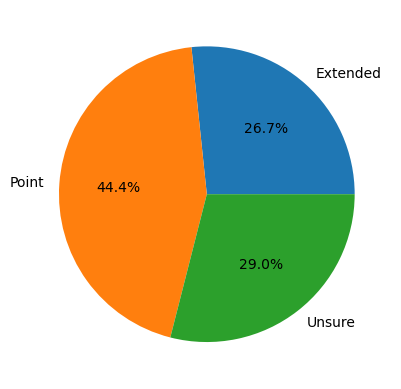

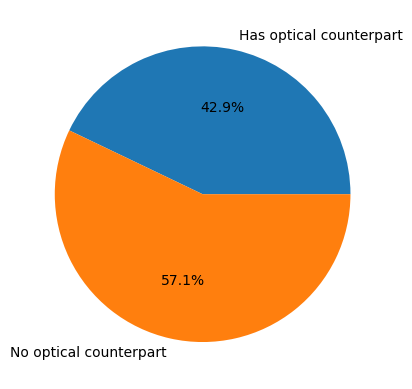

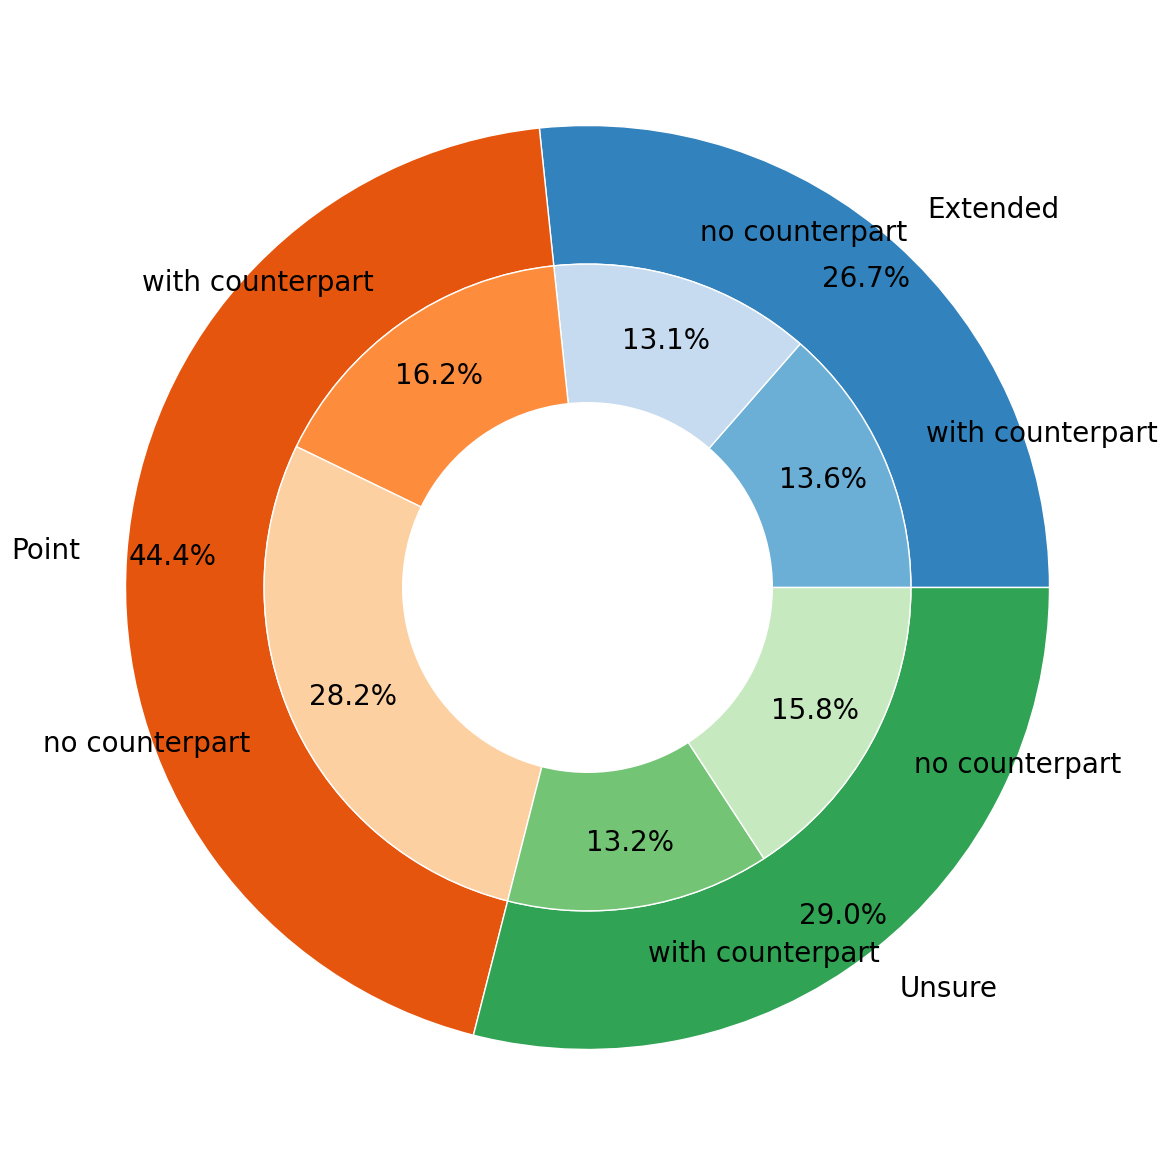

In [8]:
#First broad look at statistics and agreement between classifiers on radio morphology and optical counterparts

labels = 'Extended', 'Point', 'Unsure'
sizes = [count_Extended, count_Point,count_Unsure]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

#optical counterpart or no?

labels = 'Has optical counterpart', 'No optical counterpart'
sizes = [count_Optical_Counterpart, count_No_Optical_Counterpart]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

#Combining them into one pie chart.
size = 0.3
vals = np.array([[count_EXTplusCounterpart, count_Extended-count_EXTplusCounterpart],
                 [count_POINTplusCounterpart, count_Point-count_POINTplusCounterpart],
                [count_UNSUREplusCounterpart,count_Unsure-count_UNSUREplusCounterpart]]) #[with, without]extended and [with,without]point
fig, ax = plt.subplots(figsize=(20, 15))
cmap = plt.colormaps["tab20c"]#tab20c
print(cmap)
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 3, 5, 7, 9, 11]) 
labels = 'Extended', 'Point', 'Unsure'
ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), autopct='%1.1f%%',
       labels=labels, textprops={'fontsize': 20},pctdistance=.9)
labels = 'with counterpart', 'no counterpart', 'with counterpart', 'no counterpart', 'with counterpart','no counterpart'
ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), autopct='%1.1f%%',
       labels=labels, textprops={'fontsize': 20},
       pctdistance=.8, labeldistance=1.15)
# ax.set(aspect="equal", title='statistics on the split between extended and point, and whether they have an optical counterpart or not',fontsize= 20)
# fig.suptitle('statistics on the split between extended and point, and whether they have an optical counterpart or not', fontsize=20)
# plt.legend(loc='upper left')
# plt.show()
plt.savefig("EXT_OPT_Stats.pdf",dpi=1000)




In [9]:
#After these basic stats, I need to go through each extended source that has >=80% agreement
# on the subject having associated regions. Meaning it is not an isolated extended radio source.
# These sources are likely to be large scale radio extended structures. Visual inspections will
# confirm this

#Import data_red if it has not been done yet for the pie charts above.
# data_red = pd.read_csv('REDTEST.csv')

data_HC_Compact = pd.DataFrame()
data_HC_Structured = pd.DataFrame()
data_HC_Point = pd.DataFrame()
data_HC_Combined= pd.DataFrame()

counter=0
#The column names in the blank data_HC_Compact, must match the column names being filled into each row.
#The number of columns must hence also match or this will not work.
#This is for the Compact extended database with high confidence
while counter<=(data_red.shape[0]-3):
    if ((data_red['data.no-nearby-marked-regions-seem-associated-with-the-central-source'][counter]>=4) and (data_red['flag_rad_extended'][counter]==1)):
        new_row=pd.DataFrame({"subject_id":data_red['subject_id'][counter],
                              "data.the-radio-source-is-showing-extended-morphology":data_red['data.the-radio-source-is-showing-extended-morphology'][counter],
                              "data.yes-there-seem-to-be-associated-regions-close-to-the-central-source":data_red['data.yes-there-seem-to-be-associated-regions-close-to-the-central-source'][counter],
                              "data.no-nearby-marked-regions-seem-associated-with-the-central-source":data_red['data.no-nearby-marked-regions-seem-associated-with-the-central-source'][counter],
                              "flag_optical_counterpart":data_red['flag_optical_counterpart'][counter],
                              "flag_rad_extended":data_red['flag_rad_extended'][counter],
                              "flag_rad_point":data_red['flag_rad_point'][counter],
                              "classifications_count":data_red['classifications_count'][counter],
                              "LCurl":data_red['LCurl'][counter]},index=[0])

        data_HC_Compact=pd.concat([data_HC_Compact, new_row],axis=0,ignore_index=True)
        data_HC_Combined=pd.concat([data_HC_Combined,new_row],axis=0,ignore_index=True)
    counter=counter+1
data_HC_Compact.to_csv('HC_Compact.csv')

counter=0
#The column names in the blank data_HC_Structured, must match the column names being filled into each row.
#The number of columns must hence also match or this will not work.
#This is for the structured extended database with high confidence
while counter<=(data_red.shape[0]-3):
    if ((data_red['data.yes-there-seem-to-be-associated-regions-close-to-the-central-source'][counter]>=4) and (data_red['flag_rad_extended'][counter]==1)):
        new_row=pd.DataFrame({"subject_id":data_red['subject_id'][counter],
                              "data.the-radio-source-is-showing-extended-morphology":data_red['data.the-radio-source-is-showing-extended-morphology'][counter],
                              "data.yes-there-seem-to-be-associated-regions-close-to-the-central-source":data_red['data.yes-there-seem-to-be-associated-regions-close-to-the-central-source'][counter],
                              "data.no-nearby-marked-regions-seem-associated-with-the-central-source":data_red['data.no-nearby-marked-regions-seem-associated-with-the-central-source'][counter],
                              "flag_optical_counterpart":data_red['flag_optical_counterpart'][counter],
                              "flag_rad_extended":data_red['flag_rad_extended'][counter],
                              "flag_rad_point":data_red['flag_rad_point'][counter],
                              "classifications_count":data_red['classifications_count'][counter],
                              "LCurl":data_red['LCurl'][counter]},index=[0])

        data_HC_Structured=pd.concat([data_HC_Structured, new_row],axis=0,ignore_index=True)
        data_HC_Combined=pd.concat([data_HC_Combined,new_row],axis=0,ignore_index=True)
    counter=counter+1
data_HC_Structured.to_csv('HC_Structured.csv')

counter=0
#The column names in the blank data_HC_Point, must match the column names being filled into each row.
#The number of columns must hence also match or this will not work.
#Finally the high confidence radio point source database
while counter<=(data_red.shape[0]-3):
    if data_red['flag_rad_point'][counter]==1:
        new_row=pd.DataFrame({"subject_id":data_red['subject_id'][counter],
                              "data.the-radio-source-is-showing-extended-morphology":data_red['data.the-radio-source-is-showing-extended-morphology'][counter],
                              "data.yes-there-seem-to-be-associated-regions-close-to-the-central-source":data_red['data.yes-there-seem-to-be-associated-regions-close-to-the-central-source'][counter],
                              "data.no-nearby-marked-regions-seem-associated-with-the-central-source":data_red['data.no-nearby-marked-regions-seem-associated-with-the-central-source'][counter],
                              "flag_optical_counterpart":data_red['flag_optical_counterpart'][counter],
                              "flag_rad_extended":data_red['flag_rad_extended'][counter],
                              "flag_rad_point":data_red['flag_rad_point'][counter],
                              "classifications_count":data_red['classifications_count'][counter],
                              "LCurl":data_red['LCurl'][counter]},index=[0])

        data_HC_Point=pd.concat([data_HC_Point, new_row],axis=0,ignore_index=True)
        data_HC_Combined=pd.concat([data_HC_Combined,new_row],axis=0,ignore_index=True)
    counter=counter+1
data_HC_Point.to_csv('HC_Point.csv')

#Create the combined High Confidence table
data_HC_Combined.to_csv('HC_Combined.csv')



Struc:  132 
Point :  634 
Compact:  128
Total HC sources:  894


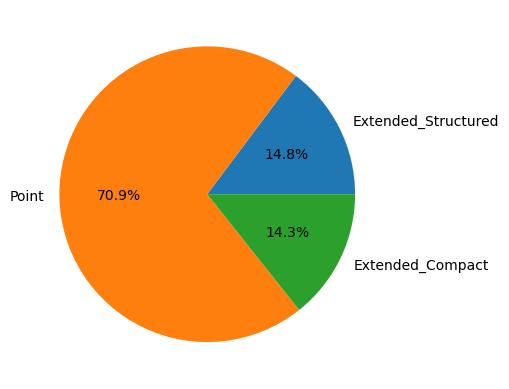

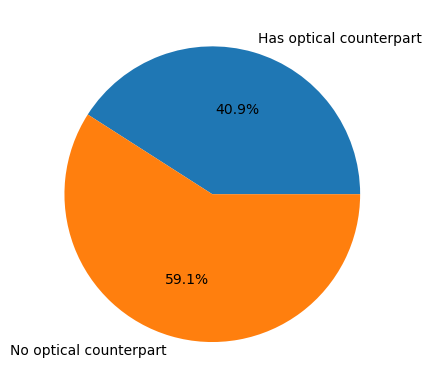

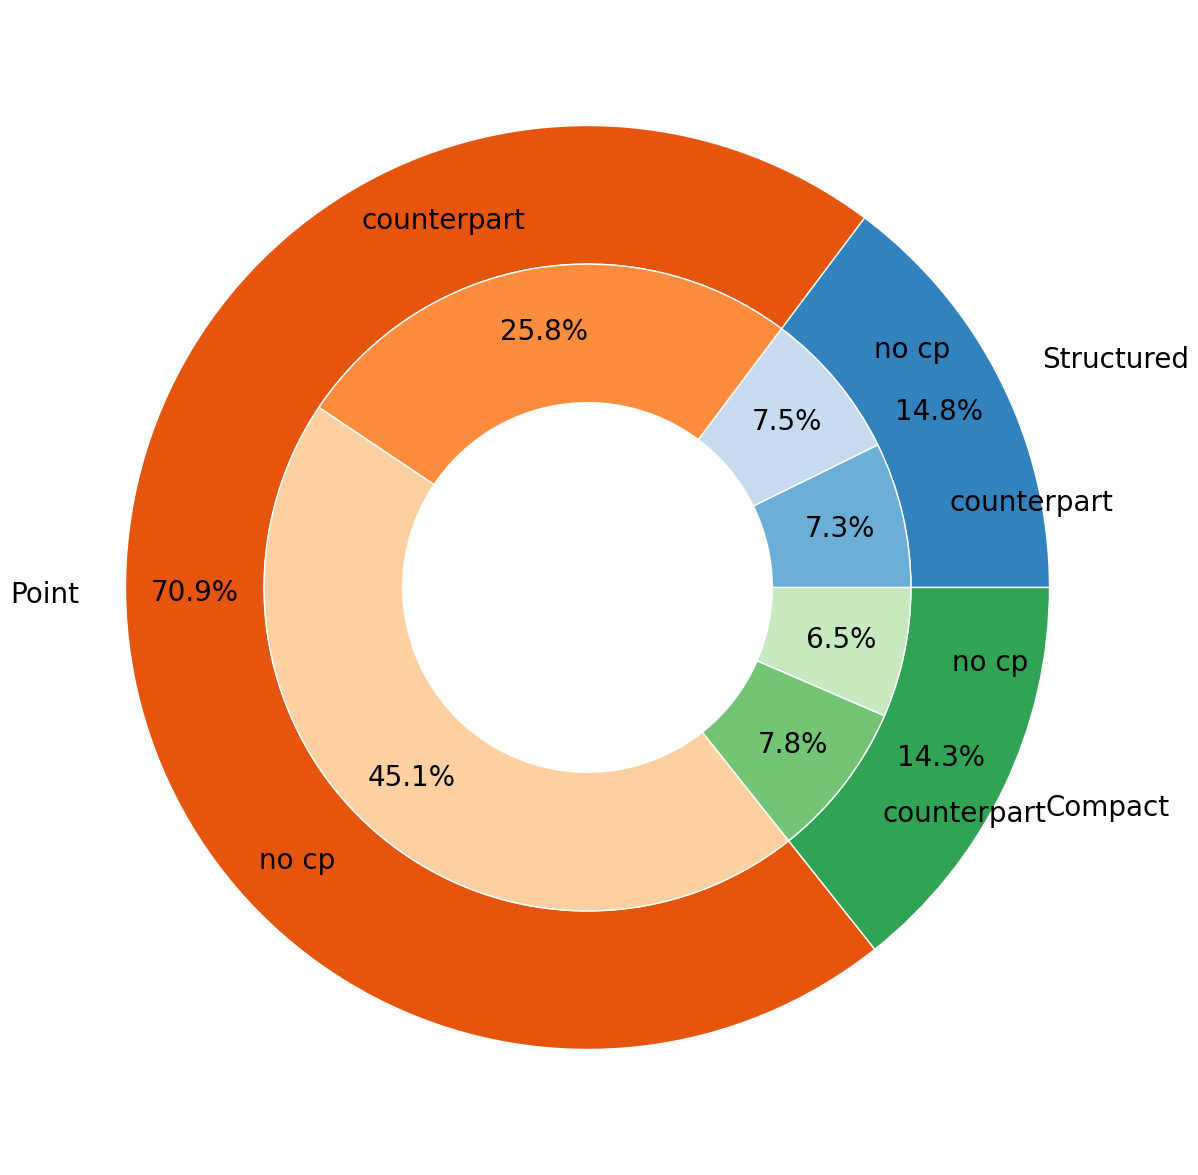

In [11]:
#Extended source here can mean one of 2 things
#1) It is a large isolated radio source i.t.o it's contours
#2) It is a source that has links to other contours, or marked regions
# and forms part of a larger extended radio structure.

#import the High confidence databases if already created:
data_HC_Structured = pd.read_csv('HC_Structured_Reviewed.csv')
# data_HC_Structured = pd.read_csv('HC_Structured.csv')
data_HC_Point = pd.read_csv('HC_Point.csv')
data_HC_Compact = pd.read_csv('HC_Compact.csv')

count_Struct=len(data_HC_Structured['subject_id'])
count_Point=len(data_HC_Point['subject_id'])
count_Compact=len(data_HC_Compact['subject_id'])

count_OptCP_Struct=0
count_OptCP_Comp=0
count_OptCP_Point=0

print("Struc: ",count_Struct,"\nPoint : ",count_Point,"\nCompact: ",count_Compact)
print("Total HC sources: ",count_Struct+count_Point+count_Compact)

for i in range(0,len(data_HC_Structured['subject_id'])):
    if(data_HC_Structured['flag_optical_counterpart'][i]==1):
        count_OptCP_Struct+=1
        
for i in range(0,len(data_HC_Point['subject_id'])):
    if(data_HC_Point['flag_optical_counterpart'][i]==1):
        count_OptCP_Point+=1

for i in range(0,len(data_HC_Compact['subject_id'])):
    if(data_HC_Compact['flag_optical_counterpart'][i]==1):
        count_OptCP_Comp+=1



labels = 'Extended_Structured', 'Point', 'Extended_Compact'
sizes = [count_Struct, count_Point, count_Compact]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

#optical counterpart or no?

labels = 'Has optical counterpart', 'No optical counterpart'
sizes = [count_OptCP_Struct+count_OptCP_Point+count_OptCP_Comp,
         count_Struct+count_Point+count_Compact-(count_OptCP_Struct+count_OptCP_Point+count_OptCP_Comp)]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

#Combining them into one pie chart.
size = 0.3
vals = np.array([[count_OptCP_Struct, count_Struct-count_OptCP_Struct],
                 [count_OptCP_Point, count_Point-count_OptCP_Point],
                [count_OptCP_Comp,count_Compact-count_OptCP_Comp]]) #[with, without]extended and [with,without]point
fig, ax = plt.subplots(figsize=(20, 15))
cmap = plt.colormaps["tab20c"]
print(cmap)
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 3, 5, 7, 9, 11]) 
labels = 'Structured', 'Point', 'Compact'
ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), autopct='%1.1f%%',
       labels=labels, textprops={'fontsize': 20},pctdistance=.85)
labels = 'counterpart', 'no cp', 'counterpart', 'no cp', 'counterpart','no cp'
ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), autopct='%1.1f%%',
       labels=labels, textprops={'fontsize': 20},
       pctdistance=.8, labeldistance=1.15)
ax.set(aspect="equal")
# fig.suptitle('statistics on the split between extended and point, and whether they have an optical counterpart or not', fontsize=20)
# plt.legend(loc='upper left')
# plt.show()
plt.savefig("HC_Str_Poi_Comp.pdf",dpi=1000)

In [11]:
#Now we have a preliminary HC database. But the structured sources need to be cut to only contain one representative source.

# Plot the images from the LCurl data entry, print what the subject ID is
# onto the image and print everything into a pdf to manually sort through
# the images and mark the images that are the most centralised in the
# extended structure as the source to keep.

#Change the import database if reviewed manually:
data_HC_Structured=pd.read_csv('HC_Structured_Reviewed.csv')
# for i in range(0,len(data_HC_Structured['subject_id'])):
#     if data_HC_Structured['keep'][i]==0:
#         data_HC_Structured=data_HC_Structured.drop(axis=0,index=i)
# print(len(data_HC_Structured))
# data_HC_Structured.to_csv('HC_Structured_Reviewed.csv')

        

#List for the individual pdf files
FileNames=[]

#Create a pdf merger instance:
merger = PdfMerger()

# comment out the keep if statement if this is the first run on a new HC_Structured.csv
for i in range(0,len(data_HC_Structured['subject_id'])):
    if((data_HC_Structured['keep'][i])==1):
        plt.figure(figsize=(6,6))
        image = io.imread(str(data_HC_Structured['LCurl'][i]))
        plt.title(str(data_HC_Structured['subject_id'][i]), fontsize=30)
        plt.imshow(image)
        plt.savefig(r"./Structured_Images/"+str(data_HC_Structured['subject_id'][i])+'.pdf', dpi=200)
        FileNames.append("./Structured_Images/"+str(data_HC_Structured['subject_id'][i])+'.pdf')
        plt.close()
#     break

#Merge into one file    
for pdf in FileNames:
    merger.append(pdf)
merger.write("./Structured_Images/"+'All_Images.pdf')
merger.close()

#IMPORTANT! I made a copy of HC_Structured.csv and called it HC_Structured_Reviewed.csv
# In that document I marked each structured source in the column "Keep" with a 1 or 0
# 1 meaning keep, 0 meaning discard obviously after manually visually inspecting them.
# I also used image comparison software to find any images that looked similar,
# and made sure that the images it reported as being very similar, were infact
# the same sources, further increasing the confidence that the numbers are correct
# in going from 213 structured to 132.



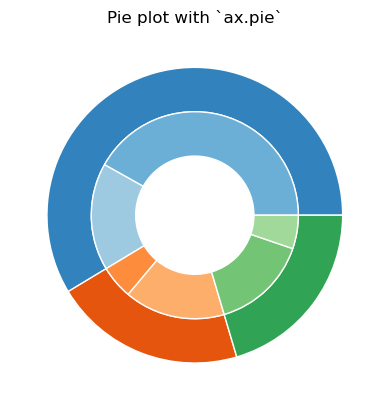

In [10]:
fig, ax = plt.subplots()

size = 0.3
vals = np.array([[80., 32.], [10., 30.], [29., 10.]]) #[with, without]extended and [with,without]point

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()